In [2]:
import pandas as pd
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
import os
from tensorflow.keras.layers import Layer, Dense, Conv1D, LayerNormalization, MultiHeadAttention
import pywt 
import seaborn as sns
from scipy import stats
from keras.callbacks import EarlyStopping

In [2]:
'''parameter setting'''
file_path = '../waimai_demand.npy'
nodes = 900
day = 61
hour = 18 # hours in each day, exclude 0:00-6:00
train_valid_days = 48
pred_step = 6
input_step = 12

first_adjacency_type = "../spatial_binary_adjacency.npy"
second_adjacency_type = "../name_menu_binary_adjacency.npy" 
third_adjacency_type = "../price_binary_adjacency.npy"

In [3]:
waimai_demand = np.load(file_path) 
waimai_demand.shape
waimai_demand_record = np.reshape(waimai_demand,[nodes,day,hour])
demand_record = np.reshape(waimai_demand,[nodes,day,hour])

waimai_std = np.std(demand_record[:,0:train_valid_days,:],axis=1)
waimai_avg = np.mean(demand_record[:,0:train_valid_days,:],axis=1)
print(waimai_std.shape,np.sum(waimai_demand))

train_valid_data = waimai_demand[:, :train_valid_days*hour] 
test_data = waimai_demand[:, train_valid_days*hour:] 

train_valid_data = train_valid_data.transpose(1, 0) 
test_data = test_data.transpose(1, 0)

print("train and validation data", train_valid_data.shape)  # 预期: (329, 329, 23, 76)
print("test data", test_data.shape)   

(900, 18) 5961975.0
train and validation data (864, 900)
test data (234, 900)


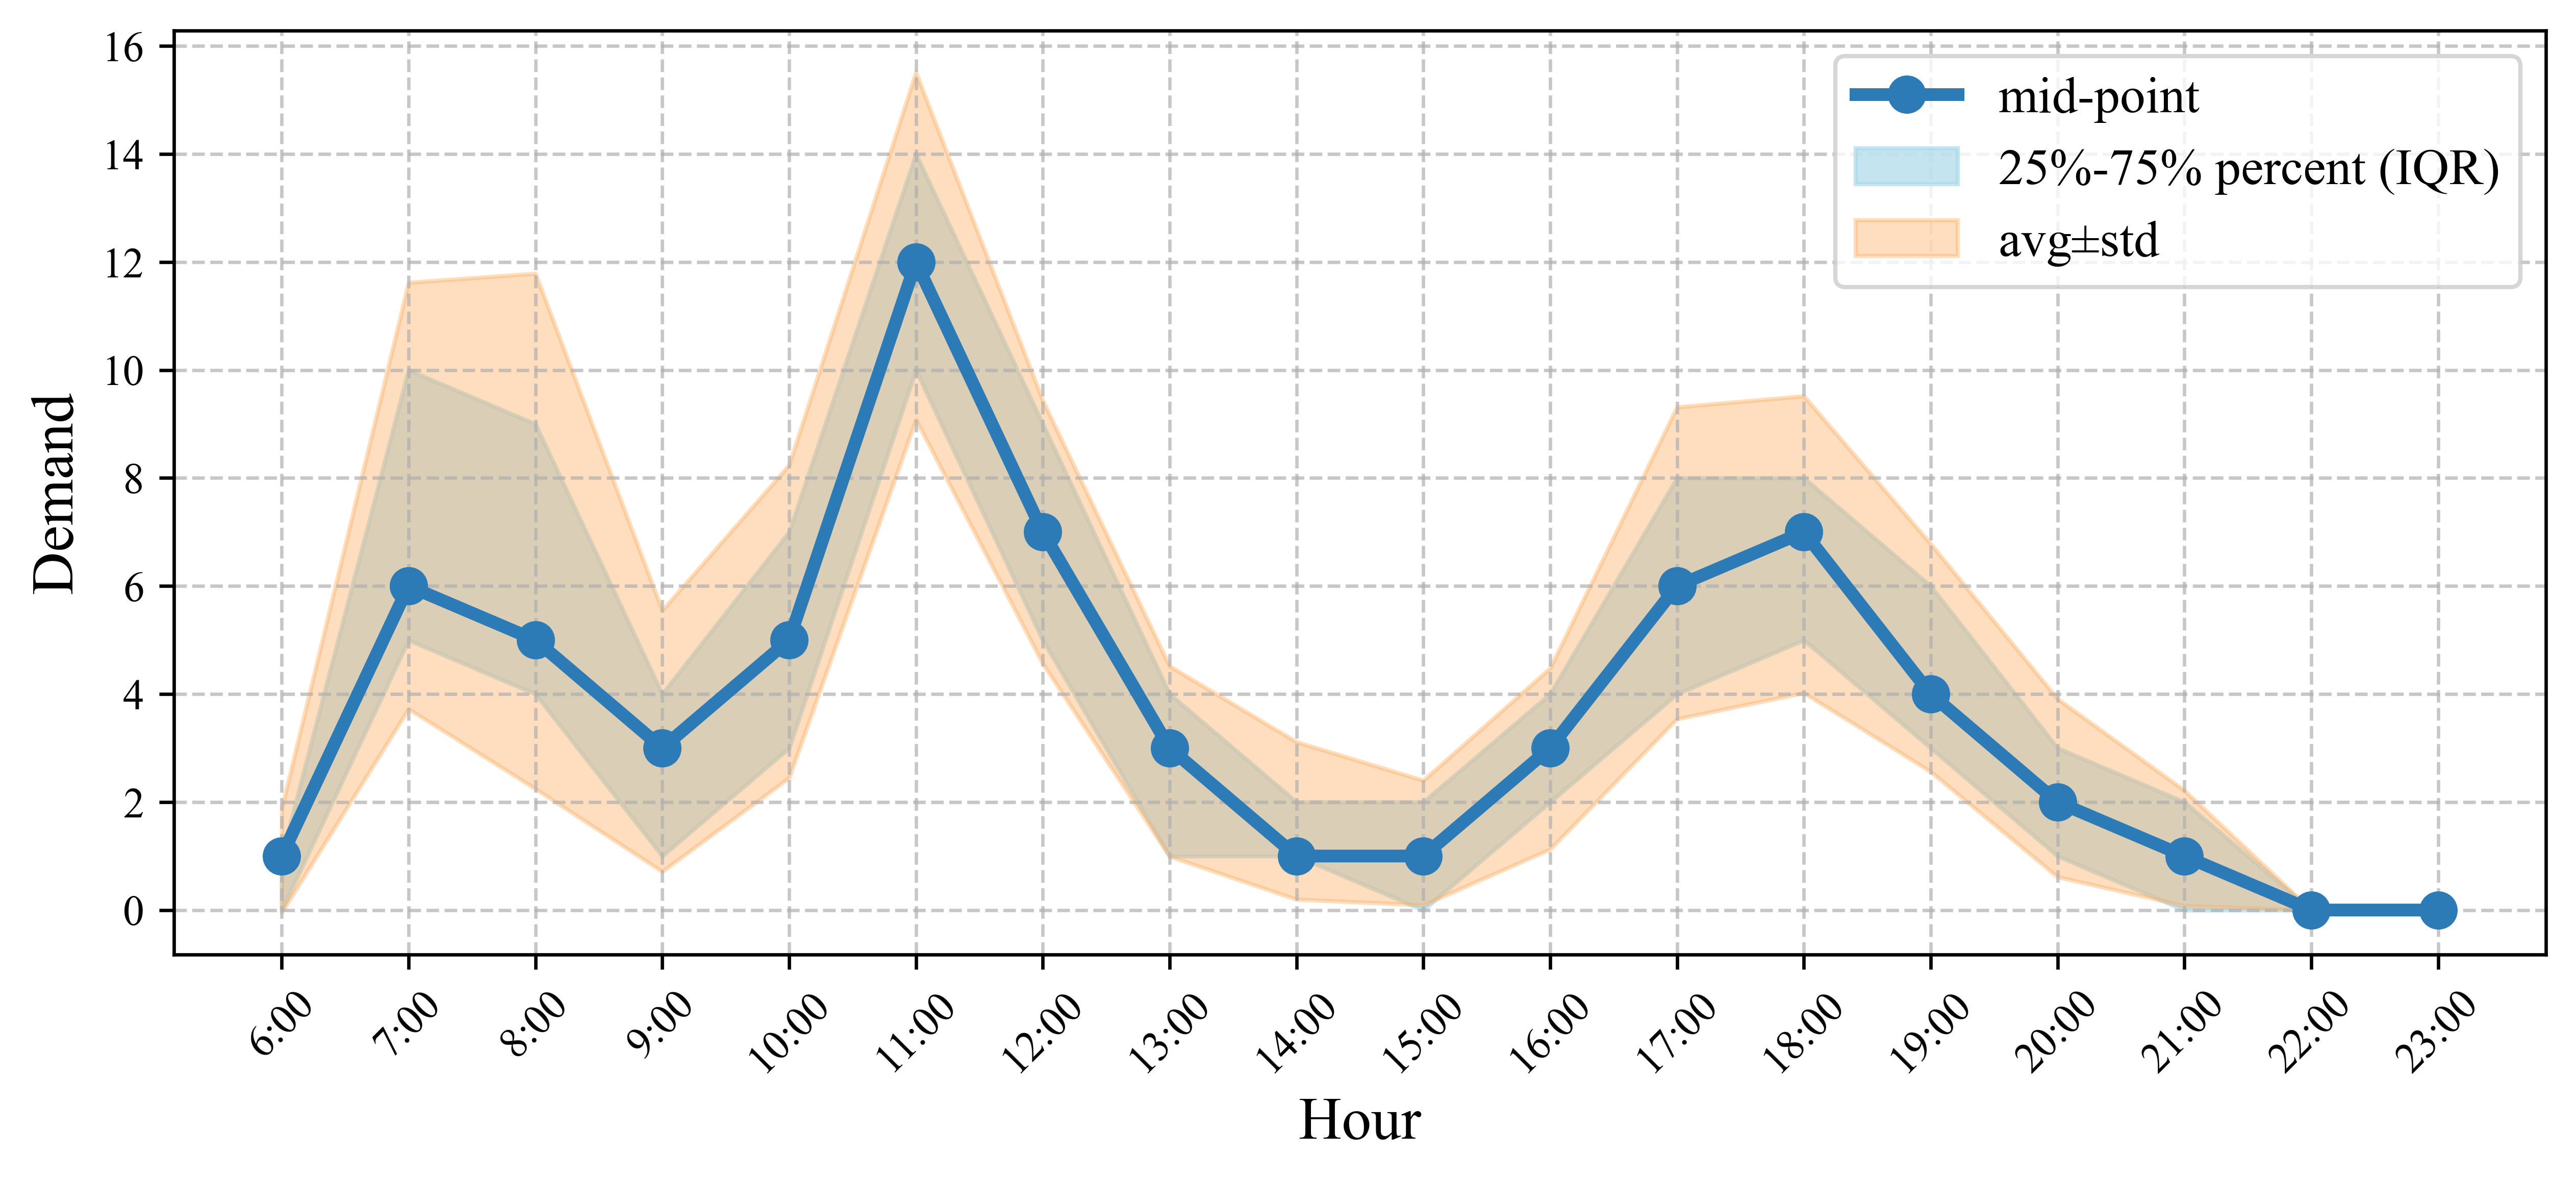

In [4]:
waimai_demand_daily = waimai_demand_record[55]   # example

hours = np.arange(6,24)
mean_demand = np.mean(waimai_demand_daily, axis=0)
std_dev = np.std(waimai_demand_daily, axis=0)
median_demand = np.median(waimai_demand_daily, axis=0)
q25 = np.percentile(waimai_demand_daily, 25, axis=0)
q75 = np.percentile(waimai_demand_daily, 75, axis=0)

plt.figure(figsize=(10, 4), dpi=600)
plt.rcParams['font.family'] = 'Times New Roman' 

plt.plot(hours, median_demand, 'o-', color='#2c7bb6', linewidth=3, markersize=8, 
         label='mid-point', zorder=10)

plt.fill_between(hours, q25, q75, color='#abd9e9', alpha=0.7, 
                label='25%-75% percent (IQR)')

plt.fill_between(hours, mean_demand - std_dev, mean_demand + std_dev, 
                color='#fdae61', alpha=0.4, label='avg±std')
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Demand', fontsize=14)
plt.xticks(hours, [f'{h}:00' for h in hours], rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right', fontsize=12)
plt.show()

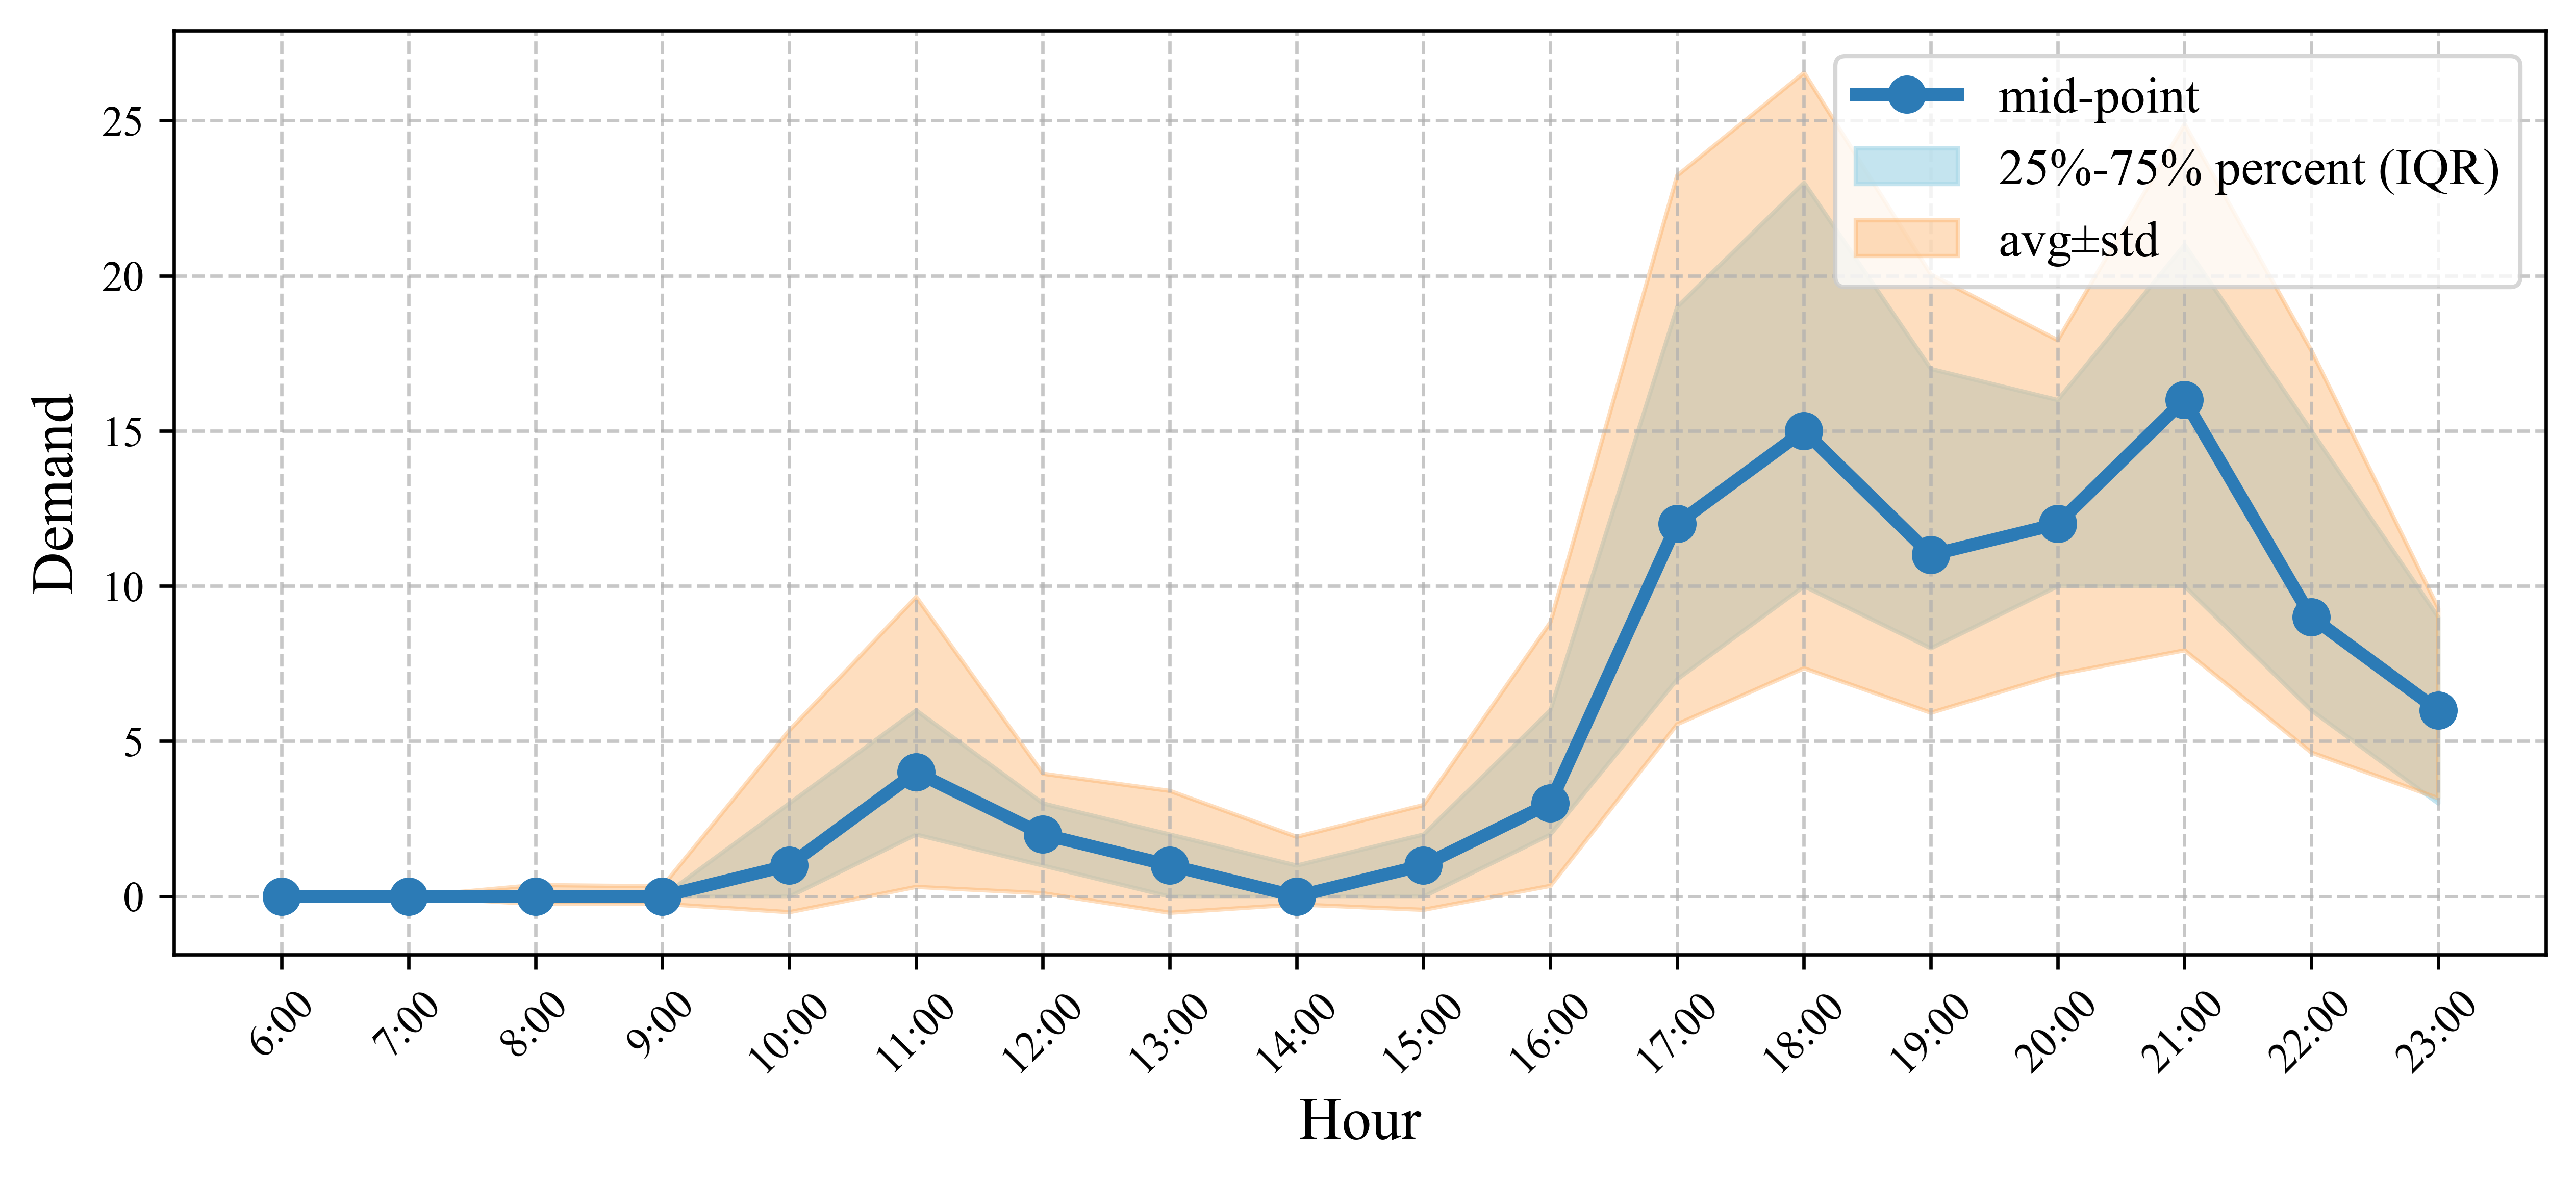

In [5]:
waimai_demand_daily = waimai_demand_record[123]   # example

hours = np.arange(6,24)
mean_demand = np.mean(waimai_demand_daily, axis=0)
std_dev = np.std(waimai_demand_daily, axis=0)
median_demand = np.median(waimai_demand_daily, axis=0)
q25 = np.percentile(waimai_demand_daily, 25, axis=0)
q75 = np.percentile(waimai_demand_daily, 75, axis=0)

plt.figure(figsize=(10, 4), dpi=600)
plt.rcParams['font.family'] = 'Times New Roman' 

plt.plot(hours, median_demand, 'o-', color='#2c7bb6', linewidth=3, markersize=8, 
         label='mid-point', zorder=10)

plt.fill_between(hours, q25, q75, color='#abd9e9', alpha=0.7, 
                label='25%-75% percent (IQR)')

plt.fill_between(hours, mean_demand - std_dev, mean_demand + std_dev, 
                color='#fdae61', alpha=0.4, label='avg±std')
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Demand', fontsize=14)
plt.xticks(hours, [f'{h}:00' for h in hours], rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right', fontsize=12)
plt.show()

In [6]:
def compute_closure_duration(demand_data):
    """
    Calculate the continuous closure duration for each restaurant at each hour.
    Parameters:
        demand_data: numpy array with shape [number_of_restaurants, number_of_timesteps]
    Returns:
        close_duration: numpy array with the same shape as demand_data
    """
    num_restaurants, num_timesteps = demand_data.shape
    close_duration = np.zeros((num_restaurants, num_timesteps), dtype=int)
    
    # Create a mask for zero values
    zero_mask = (demand_data == 0)
    
    # For each restaurant
    for i in range(num_restaurants):
        # Initialize the first timestep
        close_duration[i, 0] = 0
        
        # For subsequent timesteps
        for t in range(1, num_timesteps):
            if demand_data[i, t] != 0:
                # If currently open, closure duration is 0
                close_duration[i, t] = 0
            else:
                # If the previous timestep was open, closure duration starts at 1 (closure begins now)
                if demand_data[i, t-1] != 0:
                    close_duration[i, t] = 1
                # If the previous timestep was also closed, accumulate the duration
                else:
                    close_duration[i, t] = close_duration[i, t-1] + 1  
    return close_duration

In [7]:
allclose_duration = compute_closure_duration(waimai_demand)
allclose_duration = np.minimum(12*18,allclose_duration)

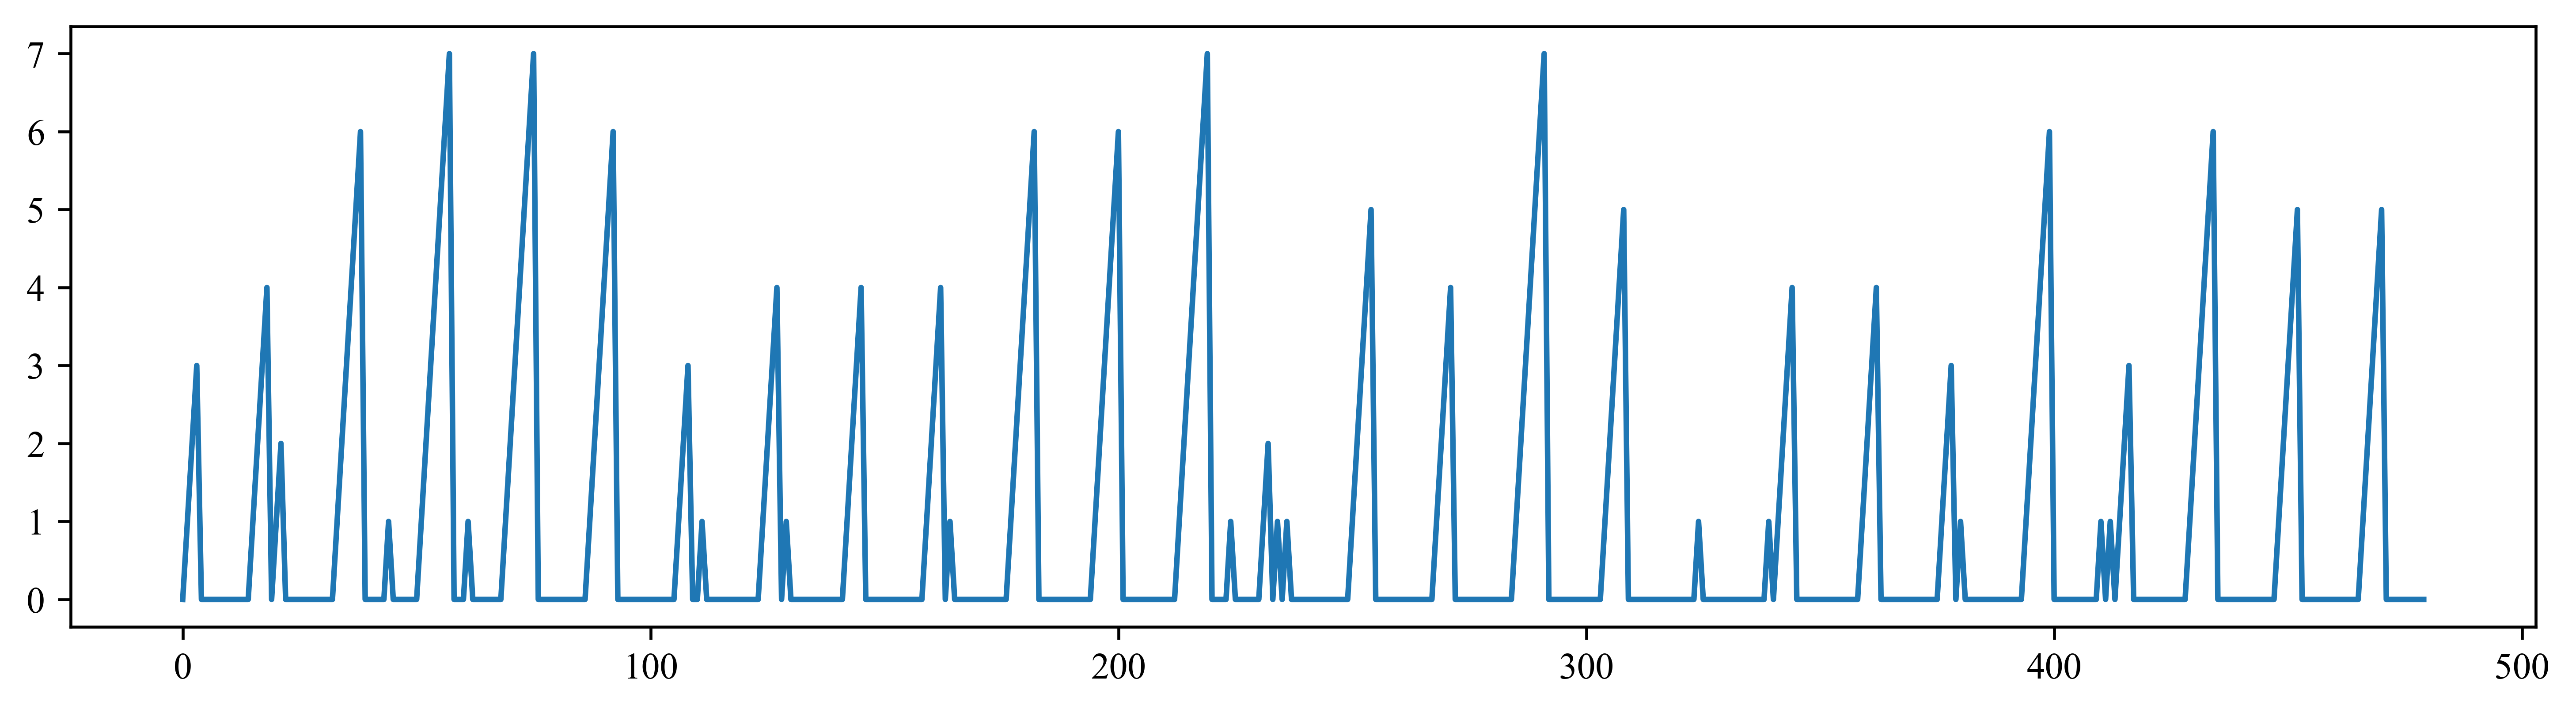

In [8]:
plt.figure(figsize=(12,3), dpi=600)
plt.plot(allclose_duration[18][0:480])

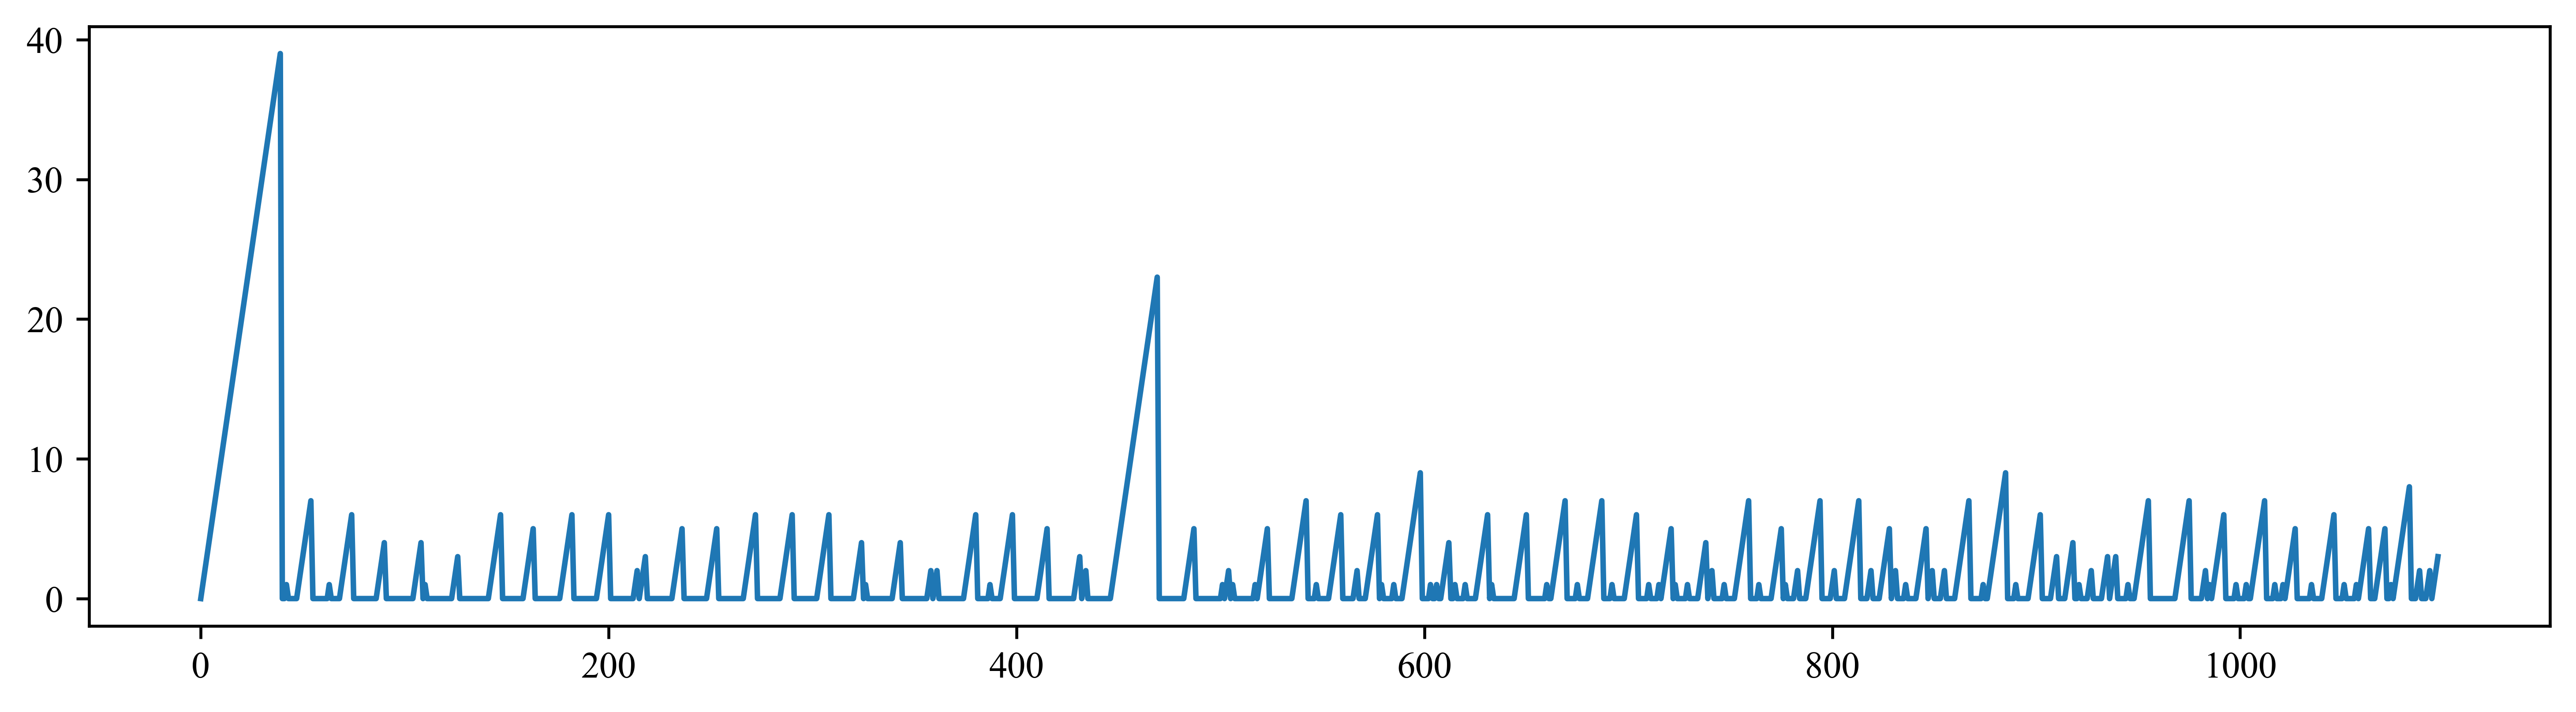

In [9]:
plt.figure(figsize=(12,3), dpi=600)
plt.plot(allclose_duration[795])

# Multi-adjacency graph construction

In [10]:
def normalize_adj(adj):
    adj += np.eye(adj.shape[0])  # Add self-connection
    degree = np.sum(adj, axis=1)
    degree_mat = np.diag(np.power(degree, -0.5))
    return degree_mat @ adj @ degree_mat

In [11]:
spatial_adj = np.load(first_adjacency_type)
spatial_adj = tf.constant(normalize_adj(spatial_adj), dtype=tf.float32)
print("spatial_adj.shape",spatial_adj.shape)

name_adj = np.load(second_adjacency_type)
name_adj = tf.constant(normalize_adj(name_adj), dtype=tf.float32)
print("name_adj.shape",name_adj.shape)

customer_adj = np.load(third_adjacency_type)
customer_adj = tf.constant(normalize_adj(customer_adj), dtype=tf.float32)
print("customer_adj.shape",customer_adj.shape)

spatial_adj.shape (900, 900)
name_adj.shape (900, 900)
customer_adj.shape (900, 900)


# Data process for train, valid, and test data

In [12]:
waimai_std_2days = np.hstack([waimai_std,waimai_std])
waimai_avg_2days = np.hstack([waimai_avg,waimai_avg])
print(waimai_avg_2days.shape,waimai_std_2days.shape)

x_train_valid = [] 
i_train_valid = [] 
c_train_valid = []
y_train_valid = [] 
for kk in range(input_step,train_valid_data.shape[0]- pred_step):
    x_train_valid = x_train_valid + [np.array(train_valid_data[kk-input_step:kk])]
    
    i_train_valid = i_train_valid + [np.concatenate([waimai_avg_2days[:,kk%hour:kk%hour+pred_step,np.newaxis],\
                                        np.array(waimai_std_2days[:,kk%hour:kk%hour+pred_step,np.newaxis])],axis=-1)]
    c_train_valid = c_train_valid + [np.array(allclose_duration[:,kk])]
    y_train_valid = y_train_valid + [np.array(train_valid_data[kk:kk+pred_step])]

x_train_valid = np.array(x_train_valid)  
i_train_valid = np.array(i_train_valid)
c_train_valid = np.array(c_train_valid)
y_train_valid = np.array(y_train_valid)    
print(x_train_valid.shape, i_train_valid.shape, c_train_valid.shape, y_train_valid.shape)

(900, 36) (900, 36)
(846, 12, 900) (846, 900, 6, 2) (846, 900) (846, 6, 900)


In [13]:
from sklearn.model_selection import train_test_split

# set train data: valid data= 7:1
x_tra, x_val, y_tra, y_val, i_tra, i_val, c_tra, c_val = train_test_split(
    x_train_valid, y_train_valid, i_train_valid, c_train_valid, test_size=1/8, shuffle=True, random_state=42)

print(f"x_train shape: {x_tra.shape}, x_valid shape: {x_val.shape}")
print(f"y_train shape: {y_tra.shape}, y_valid shape: {y_val.shape}")
print(f"i_train shape: {i_tra.shape}, y_valid shape: {i_val.shape}")
print(f"c_train shape: {c_tra.shape}, c_valid shape: {c_val.shape}")

x_train shape: (740, 12, 900), x_valid shape: (106, 12, 900)
y_train shape: (740, 6, 900), y_valid shape: (106, 6, 900)
i_train shape: (740, 900, 6, 2), y_valid shape: (106, 900, 6, 2)
c_train shape: (740, 900), c_valid shape: (106, 900)


In [14]:
x_test = [] 
i_test = []
c_test = []
y_test = [] 
for kk in range(input_step,test_data.shape[0]-pred_step):
    x_test = x_test + [np.array(test_data[kk-input_step:kk])]
    i_test = i_test + [np.concatenate([waimai_avg_2days[:,kk%hour:kk%hour+pred_step,np.newaxis],\
                                        np.array(waimai_std_2days[:,kk%hour:kk%hour+pred_step,np.newaxis])],axis=-1)]
    c_test = c_test + [np.array(allclose_duration[:,train_valid_data.shape[0]+kk])]    
    y_test = y_test + [np.array(test_data[kk:kk+pred_step])]

x_test = np.array(x_test)   
i_test = np.array(i_test)
c_test = np.array(c_test)
y_test = np.array(y_test) 
 
print(x_test.shape, y_test.shape, c_test.shape, i_test.shape)

(216, 12, 900) (216, 6, 900) (216, 900) (216, 900, 6, 2)


# Build knowledge-informed multi-adjacency dynamic graph neural network

In [15]:
class DynamicAdjGenerator(layers.Layer):
    """Dynamic adjacency matrix generator"""
    def __init__(self, static_adj, num_nodes, window_size=6):
        super().__init__()
        self.static_adj = tf.constant(static_adj, dtype=tf.float32)  # 静态基础矩阵[N,N]
        self.num_nodes = num_nodes
        self.window = window_size

        self.temporal_net = tf.keras.Sequential([
            layers.Conv1D(12, 3, activation='elu',padding="same"),   
            layers.Conv1D(2, 3, activation='elu',padding="same"),
            layers.Dropout(0.05),   
            layers.Flatten(),
            layers.LayerNormalization(),
            layers.Dense(12, activation='elu') ])
        self.dense_1 = layers.Dense(num_nodes, activation='elu')
        self.dense_2 = layers.Dense(num_nodes, activation='elu')
        
    def call(self, x):
        """Input x: [batch, T, N, C] output dynamic adjacency matrix: [batch, N, N]"""
        window_data = x[:, -self.window:]   
        temporal_weights = self.temporal_net(tf.transpose(window_data, [0,2,1,3]))  
        denweight_1 = tf.expand_dims(self.dense_1(temporal_weights),axis=1)
        denweight_2 = tf.expand_dims(self.dense_2(temporal_weights),axis=2)       
        temporal_weights = denweight_1 + denweight_2
        temporal_weights = tf.reshape(temporal_weights, [-1, self.num_nodes, self.num_nodes])
 
        # Combine static topology with dynamic pattern
        dyn_adj = self.static_adj * tf.nn.sigmoid(temporal_weights)  # [B,N,N]
        return dyn_adj

In [16]:
class DynamicGCNLayer(layers.Layer):
    def __init__(self, output_dim, activation=None):
        super().__init__()
        self.output_dim = output_dim
        self.activation = tf.keras.activations.get(activation)
    
    def build(self, input_shape):
        self.w1 = self.add_weight(shape=(input_shape[-1], self.output_dim), initializer='glorot_uniform',name='gcn_weight1')
        self.w2 = self.add_weight(shape=(input_shape[-1], self.output_dim), initializer='glorot_uniform',name='gcn_weight2')
        super().build(input_shape)
    
    def call(self, inputs, adjacency):
        """inputs: [B*T, N, F_in]
            adjacency: [B, N, N]
          output:  [B*T, N, F_out*2] """
        adj = tf.repeat(adjacency, tf.shape(inputs)[0]//tf.shape(adjacency)[0], axis=0)   
        
        h1 = tf.matmul(inputs, self.w1)  
        output1 = tf.einsum('bij,bjk->bik', adj, h1)   
        h2 = tf.matmul(inputs, self.w2)   
        output2 = tf.einsum('bij,bjk->bik', adj, h2)   
        
        output = tf.concat([output1,output2], axis=-1)
        return self.activation(output) if self.activation else output

In [17]:
def gnn_process_seasonal_trend(inputs, num_nodes, pred_len,spatial_adj, name_adj, customer_adj,individual):
    inputs = tf.transpose(inputs, perm=[0, 2, 1])  
    x = layers.DepthwiseConv1D(kernel_size=3, strides=int(input_step/pred_len), padding='same',data_format='channels_first')(inputs) 

    x = layers.Conv1D(filters=nodes, kernel_size=1, padding='same', data_format='channels_first')(x)    
    x = layers.Dropout(0.05)(x) 

    '''Three-dimensional dynamic adjacency：spatial, name-menu, price'''
    spat_adj_gen = DynamicAdjGenerator(spatial_adj, num_nodes)
    name_adj_gen = DynamicAdjGenerator(name_adj, num_nodes)
    cust_adj_gen = DynamicAdjGenerator(customer_adj, num_nodes)
    total_adj_gen = DynamicAdjGenerator(spatial_adj+name_adj+customer_adj, num_nodes)

    x = tf.reshape(x,[-1, num_nodes, 1])   
    spat_adj1 = spat_adj_gen(tf.reshape(x,[-1, pred_len, num_nodes, 1]))  
    spat_x = layers.Dense(1)(DynamicGCNLayer(18, 'swish')(x, spat_adj1)) 
    
    name_adj1 = name_adj_gen(tf.reshape(x,[-1, pred_len, num_nodes, 1]))      
    name_x = layers.Dense(1)(DynamicGCNLayer(18, 'swish')(x, name_adj1))
    
    cust_adj1 = cust_adj_gen(tf.reshape(x,[-1, pred_len, num_nodes, 1]))  
    cust_x = layers.Dense(1)(DynamicGCNLayer(18, 'swish')(x, cust_adj1)) 
    '''combine three-dimensional modules'''
    total_x = tf.concat([spat_x, name_x,cust_x],axis=-1)  
    total_adj1 = total_adj_gen(tf.reshape(total_x,[-1, pred_len, num_nodes, 3]))   
    total_x = layers.Dense(1)(DynamicGCNLayer(18, 'swish')(total_x, total_adj1)) 
    output = tf.reshape(total_x,[-1, pred_len, num_nodes])  
            
    return output

In [18]:
import tensorflow as tf
from tensorflow.keras import layers

class SpatioTemporalAttention(layers.Layer):
    def __init__(self, num_nodes, adj_matrix, head_size=32, temporal_heads=4, spatial_heads=4):
        super().__init__()
        self.num_nodes = num_nodes
        self.adj_matrix = tf.constant(adj_matrix, dtype=tf.float32)  # [N,N]

        self.temporal_attn = layers.MultiHeadAttention(
            num_heads=temporal_heads,
            key_dim=head_size,
            kernel_initializer='glorot_uniform')
        
        self.spatial_attn = EnhancedGraphAttention(
            num_heads=spatial_heads,
            key_dim=head_size,
            adj_matrix=adj_matrix)

        self.gate_net = tf.keras.Sequential([
            layers.Dense(24, activation='swish', kernel_initializer='he_normal'),
            layers.Dropout(0.05),
            layers.Dense(num_nodes, activation='sigmoid') ])

    def build(self, input_shape):
        pagerank = tf.linalg.eigh(self.adj_matrix)[1][:,-1]  # 获取主特征向量
        self.spat_pe = tf.Variable(initial_value=tf.reshape(pagerank, [1, 1, self.num_nodes]), trainable=False,name='pagerank_pe')
        self.temp_pe = self.add_weight(shape=(1, input_shape[1], 1), initializer='glorot_uniform')
        super().build(input_shape)

    def call(self, inputs):
        """forward process"""
        x = inputs + self.temp_pe * 0.5 + self.spat_pe * 0.5  # [B,T,N]
        t_attn = self.temporal_attn(x, x, use_causal_mask=True) 
        s_attn = self.spatial_attn(x)  
        gate = self.gate_net(x)
        fused = gate * t_attn + (1-gate) * s_attn
        
        return fused

class EnhancedGraphAttention(layers.Layer):
    def __init__(self, num_heads, key_dim, adj_matrix):
        super().__init__()
        self.attention = layers.MultiHeadAttention(num_heads, key_dim)
        self.adj_matrix = tf.constant(adj_matrix, dtype=tf.float32)
        self.dense = layers.Dense(adj_matrix.shape[-1], activation='elu') 
        self.norm = layers.LayerNormalization()
        
    def call(self, x): 
        x_t = tf.transpose(x, [0, 2, 1])   
        base_attn = self.attention(x_t, x_t)
        
        adj_bias = tf.einsum('nm,bnt->btm', self.adj_matrix, base_attn) 
        adj_feat = tf.transpose(adj_bias, [0, 2, 1])  

        return tf.transpose(adj_feat, [0, 2, 1])  

# Knowledge-informed network on hourly demand regularity

In [19]:
import tensorflow as tf
from tensorflow.keras import layers

class PhysicsInformedLayer(layers.Layer):
    """Physics-informed constraint layer using input statistics, with prediction adjustment."""
    def __init__(self):
        super().__init__()
        # Regularity adaptive weight networks
        self.regularity_net1 = tf.keras.Sequential([
            layers.Dense(32, activation='elu'),
            layers.Dense(12, activation='elu'),
            layers.Dense(1, activation='sigmoid')
        ])
        
        self.regularity_net2 = tf.keras.Sequential([
            layers.Dense(32, activation='elu'),
            layers.Dense(12, activation='elu'),
            layers.Dense(1, activation='sigmoid')
        ])
    
    def call(self, inputs, stats_input):
        """
        inputs: raw model predictions [batch, time_steps, num_nodes]
        stats_input: statistics input [batch, num_nodes, time_steps, 2] (mean and std)
        returns: (adjusted predictions, physics constraint loss)
        """
        batch_size = tf.shape(inputs)[0]
        pred_steps = tf.shape(inputs)[1]
        num_nodes = tf.shape(inputs)[2]
        
        # Reshape stats_input to match inputs
        avg_values = tf.transpose(stats_input[:,:,:,0], [0, 2, 1])
        std_values = tf.transpose(stats_input[:,:,:,1], [0, 2, 1])
        
        # Compute prediction deviation
        abs_deviation = tf.abs(inputs - avg_values)
        scaled_deviation = abs_deviation / (std_values + 1e-3)
        
        # Calculate regularity scores
        part1 = tf.transpose(scaled_deviation, perm=[0, 2, 1])
        regularity_score1 = self.regularity_net1(part1)
        regularity_score1 = tf.transpose(regularity_score1, perm=[0, 2, 1])
        
        regularity_score2 = self.regularity_net2(scaled_deviation)
        regularity_score_expanded = regularity_score1 + regularity_score2
        
        # Physics constraint loss
        physics_loss = regularity_score_expanded * scaled_deviation
        physics_loss = tf.reduce_mean(physics_loss)
        
        # Adjust predictions: higher regularity -> rely more on historical patterns
        adjusted_output = inputs + regularity_score_expanded * avg_values
        
        return adjusted_output, physics_loss

# Knowledge-informed network on restaurant closure impact

In [20]:
class ClosureAwareConstraint(layers.Layer):
    """Closure-aware constraint layer: longer closure duration leads to predictions closer to zero."""
    def __init__(self, max_duration=168, decay_rate=0.1):  # Default max closure 168 hours  
        super().__init__()
        self.max_duration = max_duration
        self.decay_rate = decay_rate
        
        # Decay function: closure duration -> decay factor (0-1)
        self.decay_function = tf.keras.Sequential([
            layers.Dense(32, activation='elu'),
            layers.Dense(16, activation='elu'),
            layers.Dense(1, activation='sigmoid')  # Output decay factor
        ])
    
    def build(self, input_shape):
        super().build(input_shape)
    
    def call(self, inputs, close_duration):
        """
        inputs: Raw model predictions [batch, pred_steps, num_nodes]
        close_duration: Continuous closure duration [batch, num_nodes] (at current timestep)
        returns: Closure-aware adjusted predictions and closure loss
        """
        # 1. Calculate decay factors (0-1)
        normalized_duration = tf.clip_by_value(close_duration / self.max_duration, 0.0, 1.0)
        decay_factors = self.decay_function(tf.expand_dims(normalized_duration, -1))  # [batch, num_nodes, 1]
        decay_factors = tf.squeeze(decay_factors, -1)  # [batch, num_nodes]
        
        # 2. Apply decay factors to future predictions
        decay_factors_exp = tf.expand_dims(decay_factors, 1)  # [batch, 1, num_nodes]
        decay_factors_exp = tf.repeat(decay_factors_exp, tf.shape(inputs)[1], axis=1)  # [batch, pred_steps, num_nodes]
        adjusted_output = inputs * decay_factors_exp
        
        # 3. Add closure-aware loss term
        closure_condition = tf.cast(close_duration > 18, tf.float32)  # Mask for extended closure
        closure_mask = tf.expand_dims(closure_condition, 1)
        closure_mask = tf.repeat(closure_mask, tf.shape(inputs)[1], axis=1)
        closure_loss = tf.reduce_mean(decay_factors_exp * tf.abs(inputs) * closure_mask)
        
        return adjusted_output, closure_loss

In [21]:
import keras.backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

class PositionEmbedding(Layer):
    def __init__(self, d_model=nodes):
        super().__init__()
        self.d_model = d_model
        
    def build(self, input_shape):
        position = tf.range(input_shape[1], dtype=tf.float32)  
        angle = position[:, None] / tf.pow(10000.0, tf.range(0, self.d_model, 2, tf.float32)/self.d_model)
        pe = tf.concat([tf.sin(angle), tf.cos(angle)], axis=-1)
        self.pe = pe[None, :, :]  

    def call(self, inputs): 
        return inputs + self.pe[:, :tf.shape(inputs)[1], :]

In [22]:
# Input layer
inputs = tf.keras.Input(shape=(input_step, nodes))  
demand_avg_std = tf.keras.Input(shape=(nodes, pred_step, 2))  
close_duration = tf.keras.Input(shape=(nodes,)) 
inputs2 = PositionEmbedding()(inputs) 

# Spaital-temporal neural network
waimai = gnn_process_seasonal_trend(inputs2, nodes, pred_step, spatial_adj, name_adj, customer_adj,individual=False)  # 调用新函数

waimai = layers.Dropout(0.08)(waimai)
waimai = SpatioTemporalAttention(num_nodes= nodes, adj_matrix=spatial_adj+name_adj+customer_adj,
                                 head_size=24, temporal_heads=3,spatial_heads=3)(waimai)
waimai = layers.Dropout(0.05)(waimai)

# Knowledge-informed neural network
waimai, physics_loss = PhysicsInformedLayer()(waimai, demand_avg_std)
waimai, closure_loss = ClosureAwareConstraint(max_duration=24*6, decay_rate=0.15)(waimai, close_duration)
model = tf.keras.Model(inputs=[inputs, demand_avg_std, close_duration], outputs=waimai)
model.add_loss(0.09*physics_loss+0.04*closure_loss) 

# model complie
model.compile(optimizer="Adam", loss=rmse, metrics=['mae'])
early_stopping = EarlyStopping(monitor='val_loss',  patience=20, restore_best_weights=True) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12, 900)]    0           []                               
                                                                                                  
 position_embedding (PositionEm  (None, 12, 900)     0           ['input_1[0][0]']                
 bedding)                                                                                         
                                                                                                  
 tf.compat.v1.transpose (TFOpLa  (None, 900, 12)     0           ['position_embedding[0][0]']     
 mbda)                                                                                            
                                                                                              

                                                                                                  
 tf.math.multiply (TFOpLambda)  ()                   0           ['physics_informed_layer[0][1]'] 
                                                                                                  
 tf.math.multiply_1 (TFOpLambda  ()                  0           ['closure_aware_constraint[0][1]'
 )                                                               ]                                
                                                                                                  
 tf.__operators__.add (TFOpLamb  ()                  0           ['tf.math.multiply[0][0]',       
 da)                                                              'tf.math.multiply_1[0][0]']     
                                                                                                  
 add_loss (AddLoss)             ()                   0           ['tf.__operators__.add[0][0]']   
          

Epoch 1/210
62/62 [==============================] - 13s 92ms/step - loss: 6.1228 - mae: 2.7782 - val_loss: 5.6524 - val_mae: 2.5563
Epoch 2/210
62/62 [==============================] - 4s 62ms/step - loss: 5.3788 - mae: 2.4453 - val_loss: 5.3580 - val_mae: 2.4316
Epoch 3/210
62/62 [==============================] - 4s 66ms/step - loss: 5.2606 - mae: 2.4000 - val_loss: 5.3306 - val_mae: 2.3881
Epoch 4/210
62/62 [==============================] - 4s 63ms/step - loss: 5.2063 - mae: 2.3721 - val_loss: 5.2395 - val_mae: 2.3692
Epoch 5/210
62/62 [==============================] - 4s 71ms/step - loss: 5.1788 - mae: 2.3652 - val_loss: 5.1692 - val_mae: 2.3643
Epoch 6/210
62/62 [==============================] - 4s 66ms/step - loss: 5.1273 - mae: 2.3538 - val_loss: 5.1366 - val_mae: 2.3496
Epoch 7/210
62/62 [==============================] - 4s 62ms/step - loss: 5.0954 - mae: 2.3496 - val_loss: 5.1049 - val_mae: 2.3466
Epoch 8/210
62/62 [==============================] - 4s 68ms/step - loss: 5

62/62 [==============================] - 3s 46ms/step - loss: 3.2632 - mae: 1.7760 - val_loss: 3.7471 - val_mae: 1.9334
Epoch 124/210
62/62 [==============================] - 3s 47ms/step - loss: 3.2557 - mae: 1.7728 - val_loss: 3.7633 - val_mae: 1.9397


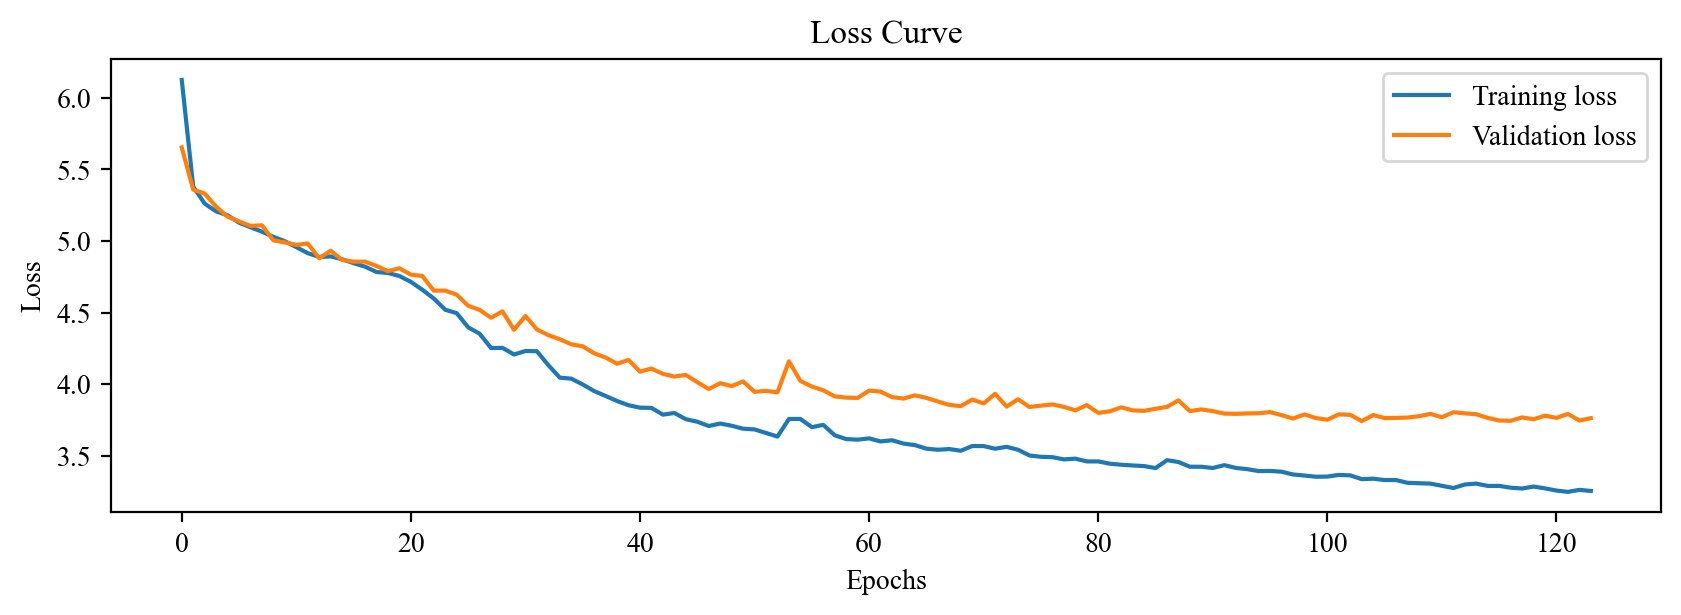

In [23]:
hist = model.fit((x_tra,i_tra, c_tra), y_tra, validation_data=((x_val,i_val, c_val), y_val), 
                 epochs= 210, batch_size=12, callbacks=[early_stopping],shuffle=True)

plt.figure(figsize=(10,3),dpi=200) 
plt.plot(hist.history['loss'], label='Training loss')
plt.plot(hist.history['val_loss'], label='Validation loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model peformance on test set

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import math

def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-6)) * 100

def wmape(y_true, y_pred):
    weights = y_true / np.sum(y_true)
    absolute_errors = np.abs((y_true - y_pred) / (y_true+ (y_true==0)*1e-6))
    return np.sum(weights * absolute_errors) * 100

def test_check(y_test, y_predict):
    MAE = mean_absolute_error(y_test, y_predict)
    RMSE = math.sqrt(mean_squared_error(y_test, y_predict))
    WMAPE = wmape(y_test, y_predict)

    print("mean_absolute_error:", MAE)
    print("mean_squared_error:", mean_squared_error(y_test, y_predict))
    print("rmse:", RMSE)
    print("WMAPE:", WMAPE)

    print("MAE:", round(MAE, 2), "RMSE:", round(RMSE, 4), "WMAPE:", round(WMAPE, 2))

In [27]:
model.save_weights("KMD-GNN"+str(pred_step)+"h.h5")

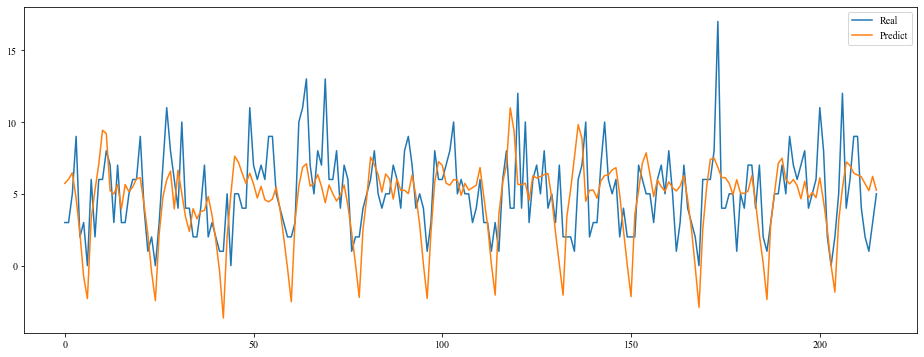

In [28]:
plt.figure(figsize=(16,6))
plt.plot(y_test[0:300,0,210].reshape([-1]))
plt.plot(pred[0:300,0,210].reshape([-1]))
plt.legend(["Real","Predict"])

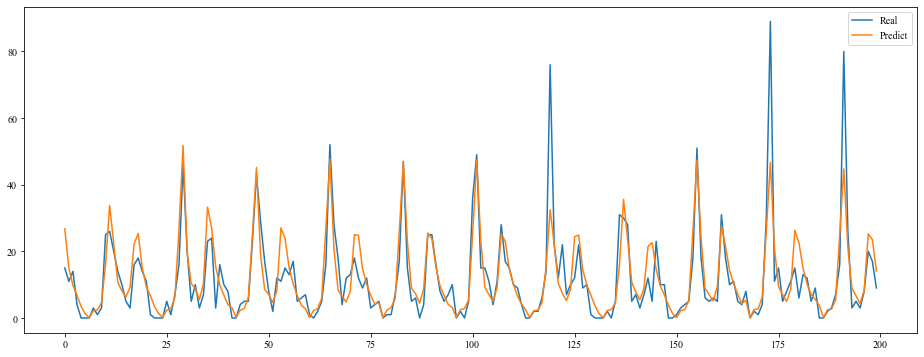

In [29]:
plt.figure(figsize=(16,6))
plt.plot(y_test[0:200,0,301])
plt.plot(pred[0:200,0,301])
plt.legend(["Real","Predict"])

In [30]:
import tensorflow as tf
from tensorflow.python.profiler import model_analyzer, option_builder

def calculate_flops(model):
    """
    Calculate FLOPs (Floating Point Operations) for a TensorFlow model.
    
    Parameters:
        model: A compiled TensorFlow model.
    
    Returns:
        Total FLOPs count, or None if calculation fails.
    """
    # Configure profiler options for FLOPs calculation
    profile_opts = option_builder.ProfileOptionBuilder.float_operation()
    
    try:
        # Create dummy input tensors matching the model's input specifications
        # Note: Adjust shape and number of inputs based on your specific model
        dummy_input = [tf.TensorSpec([1, *inp.shape[1:]]) for inp in model.inputs]
        
        # Wrap model call as a traceable function
        @tf.function
        def model_call(inputs):
            return model(inputs)
        
        # Build the computation graph for profiling
        graph = model_call.get_concrete_function(dummy_input).graph
        
        # Profile the graph to extract FLOPs information
        profiler = model_analyzer.profile(graph, options=profile_opts)
        flops = profiler.total_float_ops
        
        return flops
        
    except Exception as e:
        print(f"FLOPs calculation failed: {e}")
        return None

model_flops = calculate_flops(model)
if model_flops:
    print(f"\nModel FLOPs: {model_flops:,} operations")
    print(f"Equivalent: {model_flops/1e9:.2f} GFLOPs\n")
else:
    print("Failed to calculate FLOPs")

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`

Model FLOPs: 40,779,268 operations
Equivalent: 0.04 GFLOPs



In [31]:
pred = model.predict((x_test, i_test, c_test))
print(pred.shape)
test_check(y_test.reshape([-1]),pred.reshape([-1]))

7/7 [==============================] - 1s 62ms/step
(216, 6, 900)
mean_absolute_error: 2.3596529148151144
mean_squared_error: 19.4386159390047
rmse: 4.408924578511715
WMAPE: 33.81854143414809
MAE: 2.36 RMSE: 4.4089 WMAPE: 33.82
